<class 'pandas.core.frame.DataFrame'>
RangeIndex: 722 entries, 0 to 721
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   treat      722 non-null    float64
 1   age        722 non-null    float64
 2   education  722 non-null    float64
 3   black      722 non-null    float64
 4   hispanic   722 non-null    float64
 5   married    722 non-null    float64
 6   nodegree   722 non-null    float64
 7   re75       722 non-null    float64
 8   re78       722 non-null    float64
dtypes: float64(9)
memory usage: 50.9 KB


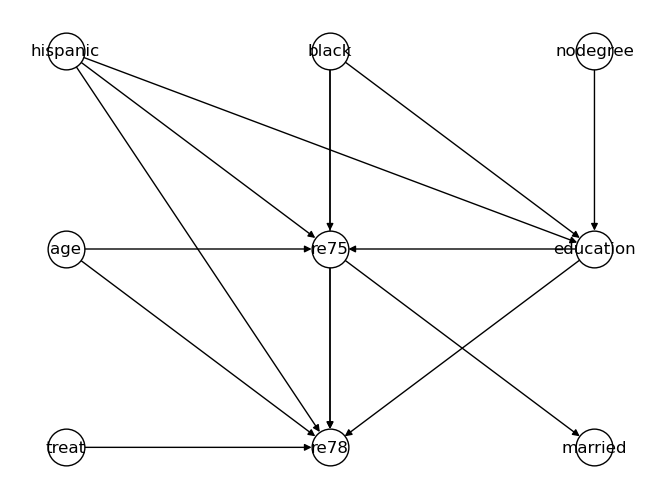

In [15]:
import pandas as pd
import numpy as np
import networkx as nx
import warnings
import dowhy
from dowhy import CausalModel
from dowhy.causal_identifier import backdoor
from IPython.display import Image, display

warnings.filterwarnings("ignore", category=FutureWarning)

data = pd.read_csv("lalonde_data.csv")

data.info()
var_names = data.columns.to_list()

graph_v0 = nx.DiGraph()

graph_v0.add_nodes_from(var_names)

graph_v0.add_edges_from([(var_names[0], var_names[8]), (var_names[1], var_names[7]), (var_names[1], var_names[8]), 
                  (var_names[2], var_names[7]), (var_names[2], var_names[8]), (var_names[6], var_names[2]), 
                  (var_names[7], var_names[5]), (var_names[7], var_names[8]), (var_names[3], var_names[2]), (var_names[4], var_names[2]),
                  (var_names[3], var_names[7]), (var_names[4], var_names[7]), (var_names[3], var_names[8]), (var_names[4], var_names[8])])
                    # (var_names[8], var_names[5])])

coordinates = [(-1,-1), (-1, 0), (1, 0), (0, 1), (-1, 1), (1, -1), (1, 1), (0, 0), (0, -1)]
pos= {key: val for key, val in zip(var_names, coordinates)}

nx.draw(graph_v0, pos= pos, with_labels=True, node_size=700, node_color='w', edgecolors ='black')
nx.write_gml(graph_v0, "backdoor_criterion_graph.gml")

In [16]:
bd = backdoor.Backdoor(graph_v0, 'education', 're78')
adjustment_variables = pd.DataFrame(columns=['path', 'colliders(and descendants)', 'non_colliders'])

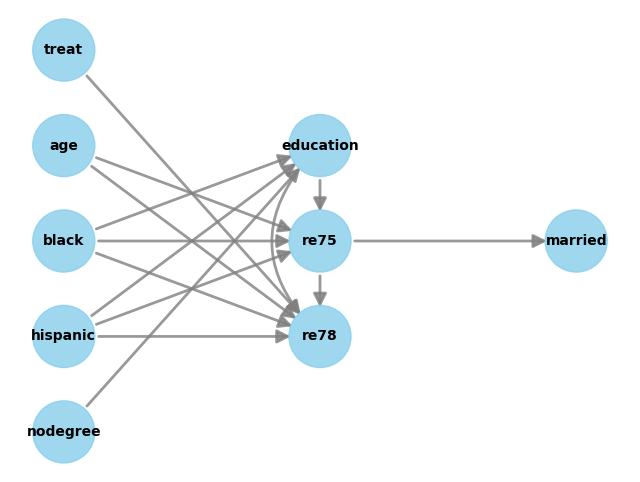

In [17]:
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string

model=CausalModel(
    data = data,
    treatment='education',
    outcome='re78',
    graph=gml_graph
)
model.view_model() 

In [18]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                              
────────────(E[re78|hispanic,black])
d[education]                        
Estimand assumption 1, Unconfoundedness: If U→{education} and U→re78 then P(re78|education,hispanic,black,U) = P(re78|education,hispanic,black)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢     d            ⎛     d                  ⎞  ⎥
E⎢───────────(re₇₈)⋅⎜───────────([education])⎟  ⎥
 ⎣d[nodegree]       ⎝d[nodegree]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→re78 then ¬(U →→{nodegree})
Estimand assumption 2, Exclusion: If we remove {nodegree}→{education}, then ¬({nodegree}→re78)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [19]:
identifier = model.identifier
identifier.identify_backdoor(model._graph._graph, model._treatment, model._outcome, list(model._graph.get_all_nodes(include_unobserved=False)))

[{'backdoor_set': ('hispanic', 'treat', 'nodegree', 'age', 'black')},
 {'backdoor_set': ('hispanic', 'black')}]

In [20]:
# Estimating treatment effect with vaious methods

estimate_linreg = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print("backdoor.linear_regression ATE :", estimate_linreg.value)

backdoor.linear_regression ATE : 276.70370006250687


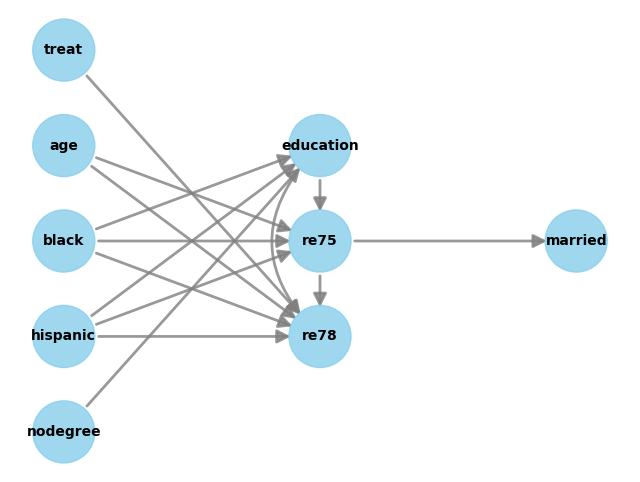

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                              
────────────(E[re78|hispanic,black])
d[education]                        
Estimand assumption 1, Unconfoundedness: If U→{education} and U→re78 then P(re78|education,hispanic,black,U) = P(re78|education,hispanic,black)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                            -1⎤
 ⎢     d            ⎛     d                  ⎞  ⎥
E⎢───────────(re₇₈)⋅⎜───────────([education])⎟  ⎥
 ⎣d[nodegree]       ⎝d[nodegree]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→re78 then ¬(U →→{nodegree})
Estimand assumption 2, Exclusion: If we remove {nodegree}→{education}, then ¬({nodegree}→re78)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

backdoor.propensity_score_matching ATE: -2374.114966398876
backdoor.propensity_score_stratification ATE : 4654.120384575102
backdoor.propensit

In [21]:
# make treatment variable binary
data_binary = data.copy()   
data_binary['education'] = data_binary['education'].apply(lambda x: 1 if x > 12 else 0)
display_data = data_binary.copy()
model=CausalModel(
    data = data_binary,
    treatment='education',
    outcome='re78',
    graph=gml_graph
)
model.view_model()

identified_estimand_binary = model.identify_effect()

print(identified_estimand_binary)

identifier = model.identifier
identifier.identify_backdoor(model._graph._graph, model._treatment, model._outcome, list(model._graph.get_all_nodes(include_unobserved=False)))

estimate_matching = model.estimate_effect(identified_estimand_binary, method_name="backdoor.propensity_score_matching")
print("backdoor.propensity_score_matching ATE:", estimate_matching.value)

estimate_strat = model.estimate_effect(identified_estimand_binary, method_name="backdoor.propensity_score_stratification")
print("backdoor.propensity_score_stratification ATE :", estimate_strat.value)

estimate_weight = model.estimate_effect(identified_estimand_binary, method_name="backdoor.propensity_score_weighting")
print("backdoor.propensity_score_weighting ATE :", estimate_weight.value)



threshold for education: propensity score matching, stratification, weighting
```
5:  -199.53     nan
6:  -272.80     563.94      1435.56
7:  2719.71     672.53      817.39
8:  4604.79     839.63      833.58
9: -1272.04     197.93      206.56
10:  199.84     502.49      512.37
11:-2650.90     1218.71     1246.84
12:-2374.       4654.12     3444.40
...
```

Refute: Add a random common cause
Estimated effect:276.70370006250687
New effect:3572.245492832526
p value:0.0

Refute: Use a Placebo Treatment
Estimated effect:276.70370006250687
New effect:65.99191459017621
p value:0.8200000000000001

Refute: Use a subset of data
Estimated effect:276.70370006250687
New effect:3286.264127473488
p value:0.020000000000000018



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


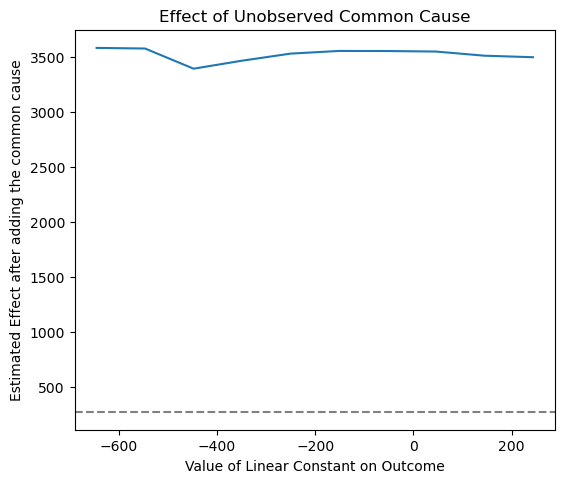

Refute: Add an Unobserved Common Cause
Estimated effect:276.70370006250687
New effect:(3391.131634919074, 3579.886929749352)



In [22]:
res_random_linreg=model.refute_estimate(identified_estimand, estimate_linreg, method_name="random_common_cause")
print(res_random_linreg)

res_placebo=model.refute_estimate(identified_estimand, estimate_linreg, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand, estimate_linreg, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand, estimate_linreg, method_name="add_unobserved_common_cause")
print(res_add)


Refute: Add a random common cause
Estimated effect:-2374.114966398876
New effect:-2374.1149663988754
p value:1.0

Refute: Use a Placebo Treatment
Estimated effect:-2374.114966398876
New effect:26.183591717728813
p value:0.98

Refute: Use a subset of data
Estimated effect:-2374.114966398876
New effect:5149.360439648084
p value:0.5



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


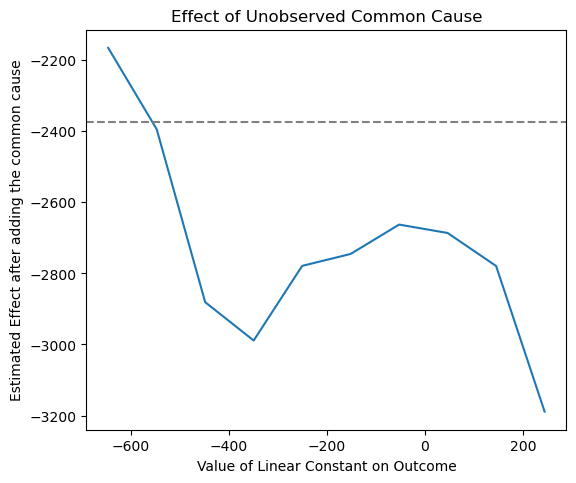

Refute: Add an Unobserved Common Cause
Estimated effect:-2374.114966398876
New effect:(-3188.834296763318, -2165.29096681759)

Refute: Add a random common cause
Estimated effect:4654.120384575102
New effect:4654.1203845751015
p value:1.0



In [23]:
res_random_matching=model.refute_estimate(identified_estimand_binary, estimate_matching, method_name="random_common_cause")
print(res_random_matching)

res_placebo=model.refute_estimate(identified_estimand_binary, estimate_matching, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand_binary, estimate_matching, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand_binary, estimate_matching, method_name="add_unobserved_common_cause")
print(res_add)

res_random_strat=model.refute_estimate(identified_estimand_binary, estimate_strat, method_name="random_common_cause")
print(res_random_strat)

Refute: Add a random common cause
Estimated effect:3444.40478267648
New effect:3444.4047826764804
p value:1.0

Refute: Use a Placebo Treatment
Estimated effect:3444.40478267648
New effect:13.195708623586906
p value:0.96

Refute: Use a subset of data
Estimated effect:3444.40478267648
New effect:3576.8557305219356
p value:0.78



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


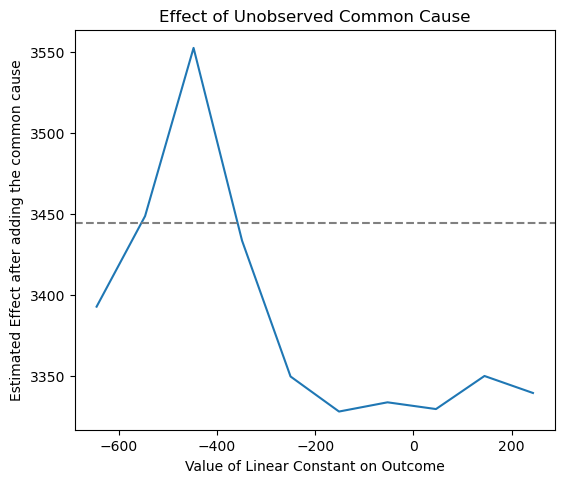

Refute: Add an Unobserved Common Cause
Estimated effect:3444.40478267648
New effect:(3328.002046141136, 3552.5040095168088)



In [24]:
res_random_weight=model.refute_estimate(identified_estimand_binary, estimate_weight, method_name="random_common_cause")
print(res_random_weight)

res_placebo=model.refute_estimate(identified_estimand_binary, estimate_weight, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand_binary, estimate_weight, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand_binary, estimate_weight, method_name="add_unobserved_common_cause")
print(res_add)

Refute: Add a random common cause
Estimated effect:3444.40478267648
New effect:3444.4047826764804
p value:1.0

Refute: Use a Placebo Treatment
Estimated effect:3444.40478267648
New effect:118.20335431873758
p value:0.8200000000000001

Refute: Use a subset of data
Estimated effect:3444.40478267648
New effect:3363.7747699944566
p value:1.0



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


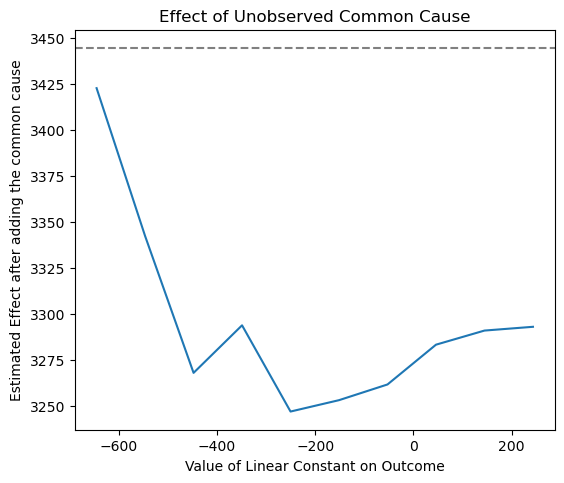

Refute: Add an Unobserved Common Cause
Estimated effect:3444.40478267648
New effect:(3247.1856188964903, 3422.572580232126)



In [25]:
res_random_propensity=model.refute_estimate(identified_estimand_binary, estimate_weight, method_name="random_common_cause")
print(res_random_propensity)

res_placebo=model.refute_estimate(identified_estimand_binary, estimate_weight, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand_binary, estimate_weight, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand_binary, estimate_weight, method_name="add_unobserved_common_cause")
print(res_add)



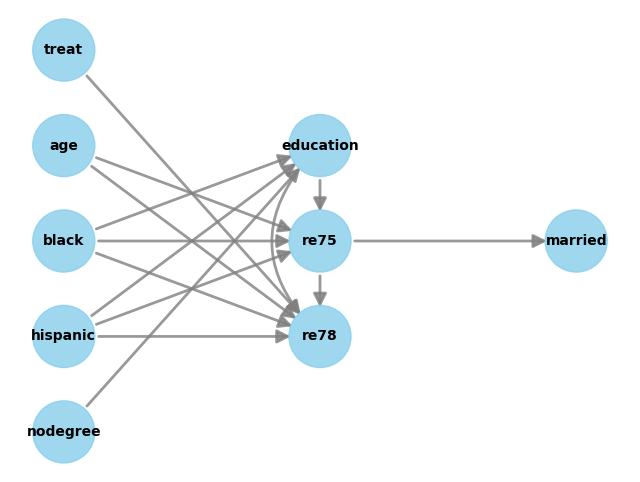

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d             
────────(E[re₇₈])
d[treat]         
Estimand assumption 1, Unconfoundedness: If U→{treat} and U→re78 then P(re78|treat,,U) = P(re78|treat,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

backdoor.linear_regression ATE : 828.2248882260001


In [30]:
model=CausalModel(
    data = data,
    treatment='treat',
    outcome='re78',
    graph=gml_graph
)
model.view_model()

identified_estimand_treat = model.identify_effect()

print(identified_estimand_treat)

identifier_treat = model.identifier
identifier_treat.identify_backdoor(model._graph._graph, model._treatment, model._outcome, list(model._graph.get_all_nodes(include_unobserved=False)))

# estimate_matching = model.estimate_effect(identified_estimand_treat, method_name="backdoor.propensity_score_matching")
# print("backdoor.propensity_score_matching ATE:", estimate_matching.value)

# estimate_strat = model.estimate_effect(identified_estimand_treat, method_name="backdoor.propensity_score_stratification")
# print("backdoor.propensity_score_stratification ATE :", estimate_strat.value)

# estimate_weight = model.estimate_effect(identified_estimand_treat, method_name="backdoor.propensity_score_weighting")
# print("backdoor.propensity_score_weighting ATE :", estimate_weight.value)

estimate_regression = model.estimate_effect(identified_estimand_treat, method_name="backdoor.linear_regression")
print("backdoor.linear_regression ATE :", estimate_regression.value)


In [31]:
# res_random_matching=model.refute_estimate(identifed_estimand_treat, estimate_matching, method_name="random_common_cause")
# print(res_random_matching)

# res_placebo=model.refute_estimate(identified_estimand_treat, estimate_matching, method_name="placebo_treatment_refuter")
# print(res_placebo)

# res_subset=model.refute_estimate(identified_estimand_treat, estimate_matching, method_name="data_subset_refuter")
# print(res_subset)

# res_add=model.refute_estimate(identified_estimand_treat, estimate_matching, method_name="add_unobserved_common_cause")
# print(res_add)

# res_random_strat=model.refute_estimate(identified_estimand_treat, estimate_strat, method_name="random_common_cause")
# print(res_random_strat)

# res_random_weight=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="random_common_cause")
# print(res_random_weight)

# res_placebo=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="placebo_treatment_refuter")
# print(res_placebo)

# res_subset=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="data_subset_refuter")
# print(res_subset)

# res_add=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="add_unobserved_common_cause")
# print(res_add)

# res_random_propensity=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="random_common_cause")
# print(res_random_propensity)

# res_placebo=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="placebo_treatment_refuter")
# print(res_placebo)

# res_subset=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="data_subset_refuter")
# print(res_subset)

# res_add=model.refute_estimate(identified_estimand_treat, estimate_weight, method_name="add_unobserved_common_cause")
# print(res_add)

res_random_linreg=model.refute_estimate(identified_estimand_treat, estimate_linreg, method_name="random_common_cause")
print(res_random_linreg)

res_placebo=model.refute_estimate(identified_estimand_treat, estimate_linreg, method_name="placebo_treatment_refuter")
print(res_placebo)

res_subset=model.refute_estimate(identified_estimand_treat, estimate_linreg, method_name="data_subset_refuter")
print(res_subset)

res_add=model.refute_estimate(identified_estimand_treat, estimate_linreg, method_name="add_unobserved_common_cause")
print(res_add)

Refute: Add a random common cause
Estimated effect:276.70370006250687
New effect:883.249316039112
p value:0.0



/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1967: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
/home/viki/miniconda3/envs/causal_data_science_env/lib/python3.9/site-packages/statsmodels/regre

Refute: Use a Placebo Treatment
Estimated effect:276.70370006250687
New effect:0.0
p value:1.0

